<a href="https://colab.research.google.com/github/ssanudo/ProcesamDigImagTP/blob/main/TP4/PDI_TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Trabajo Práctico Nro. 4**

#Perteneciente a: Silvana Sañudo

#**Histograma de Luminancias**
Para este TP se desea que implementen lo siguiente:
* Generar una función que como parámetro de entrada tome la luminacia de una imagen y un numero entero de contadores y como salida obtengamos el histograma respectivo. (la función debe ser desarrollada por ustedes no mediante funciones de librería que ya la implementen). Mostrar el histograma respectivo para 5 valores de contadores diferentes.
* Buscar dos imágenes con problemas de iluminación (una oscura y otra muy brillante, como las mostradas en las filminas de la clase Pag. 7). Verificar la premisa de que al multiplicar la luminancia por un valor alfa, el problema de iluminación no se corrige. Mostrar la imagen original, la resultante y sus respectivos histogramas, para un valor alfa dado.
Implementar las funciones: Lineal a trozos para un valor Y_min y Y_max como parámetros de la función, raíz cuadrada y potencia cuadrática. Para estas usar las imágenes anteriores y mostrar cómo cambio la imagen y el histograma después de aplicar el filtro a la imagen.



#Generalidades

En el presente trabajo se muestra el efecto de la manipulación del histograma de luminancia sobre las imágenes. Se trabajará con imágenes que presentan efectos cualitativos determinados, a efectos de ver el método mas adecuado para corregirlas.
Se utilizará una imágen oscura, cuyo histograma estará mayormente distribuído en la zona baja; una imágen clara, brillante, cuyo histograma estará mayormente cesgado a las luminancias cercanas a uno. Y algunas imágenes donde el histograma se concentra en una porción del eje de luminancias, por lo que es difícil destinguir objetos, se nota una falta de contraste.

Para describir los efectos cuantitativamente, se utilizan histogramas, donde el eje X corresponde al valor de luminancia, y el eje Y a la frecuencia o porcentaje de píxeles que tienen una determinada luminancia. El eje X se divide en bins o cajones que serán los que almacenen el número de píxeles cuyas luminancias caigan dentro del rango determinado por la extensión del cajón sobre el eje. Para el presente trabajo se trabaja mayormente con 10 cajones, con lo que se logra una buena aproximación de la distribución.

# Operaciones (Ecualización)

A continuación se especifican las operaciones que se realizarán sobre la Luminancia (Y) de manera de modificar el histograma de la imágen:

* Multiplicación por un escalar $-> Y'=ctte * Y$
* Raíz cuadrada $-> Y'=sqrt(Y)$ Desparrama luminancias bajas y comprime las altas de manera suave.
* Potencia cuadrada $-> Y'=Y * Y$ Desparrama luminancias altas y comprime las bajas de manera suave.
* Histogram Stretch: Cuando el histograma se encuentra comprimido en un rango de Y, lo estiro a $[0,1]$ para ver mayor contraste. Se debe tener cuidado al seleccionar los umbrales de luminancia, para no perder información. $Y>Ymax$ van a blanco, white out; y $Y<Ymin$ van a negro, black out.



#Librerías a utilizar:

In [2]:

#Librerías
import numpy as np
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


#Funciones a utilizar:

Entre otras, se sumaron las funciones requeridas para generar los histogramas:
* **GeneroHistPorc(im,nBins)**: Genera Histograma de Luminancias ingresando la imágen y nro de bins requeridos, eje Y es porcentual respecto al nro de pixeles total.
* **GeneroHistCuenta(im,nBins)**: Genera Histograma de Luminancias ingresando la imágen y nro de bins requeridos, eje Y es el nro de pixeles que cae en cada bin.
* **GeneroHistCuentaRango(im,nBins,Ymin,Ymax)**:  Genera Histograma de Luminancias en el rango especificado, ingresando la imágen y nro de bins requeridos, eje Y es el nro de pixeles que cae en cada bin.

#Comentario: 

En el práctico generé el eje Y de bines (sus rangos) iguales, dividiendo el eje de cero a uno, cosa que no pasa en la función de Numpy, por lo que no pude compararlos. No sé cómo genera las divisiones en el eje X Numpy.
Igualmente, para analizar y comparar histogramas, utilicé una superposición generada con numpy, ya que no llegué a emularla con las funciones propias, pero se podría hacer.

In [133]:


def ImgShapeShow(im):#muestra datos de forma del arreglo obtenido de las imágenes
  print('Tamaño del arreglo',im.shape, 'donde', im.shape[0], 'x',im.shape[1],'es el tamaño de la imágen en píxeles, y ',im.shape[2], 'es el valor RGB de cada uno de dichos píxeles' )
  

def open_img(file_path):#Abre la imágen, y muestra datos de forma
  im=imageio.imread(file_path)
  ImgShapeShow(im)
  if (im.shape[2]==4):im=im[:,:,0:3]
  im = im.astype(np.int)
  return im

def save_img(im,imgName): #guarda la imagen con el nombre imgName
  imgName=imgName+'.png'
  imageio.imwrite(imgName, im.astype(np.uint8))

def normalizeRGB(x):return np.array((x - 0) / (255))
#Normaliza [0-255] RGB de la imagen en el rango [0,1], x es el arreglo de RGB de la img.

def normalizeY(y,yMin,yMax):return np.array((y - yMin) / (yMax-yMin))
#Normaliza y, lo estira, a [0,1], y es el arreglo de Luminancia de la img.


#Defino las matrices de conversión, de RGB a YIQ y viseversa.
rgb2yiq=np.array([[0.299,0.587,0.114],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
#print(rgb2yiq)
yiq2rgb=np.array([[1,0.9663,0.621],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
#print(yiq2rgb)

def RGB2YIQ(im): #función que convierte de RGB a YIQ de una imágen
  #Normalizo valores RGB de 0-255 a 0-1
  imNorm=normalizeRGB(im.copy())
  #Obtengo valores de YIQ 
  im_YIQ=np.dot(imNorm, rgb2yiq.T)
  return im_YIQ

def RGB2Y(im): #función que convierte de RGB a YIQ de una imágen
  #Normalizo valores RGB de 0-255 a 0-1
  imNorm=normalizeRGB(im.copy())
  #Obtengo valores de YIQ 
  im_YIQ=np.dot(imNorm, rgb2yiq.T)
  im_YIQ[:,:,0][im_YIQ[:,:,0]>=1]=1
  im_YIQ[:,:,0][im_YIQ[:,:,0]<0]=0
  return im_YIQ[:,:,0]


def HistY(im,nBins):#Función que genera el histograma de luminancia de una img, co el nro Bins indicado.
  e=GeneroHistPorc(im,nBins)
  return e 


def ModifyYIQ(im,alfa,beta): #función que altera el YIQ de una imágen, con alfa como coef de Luminancia, y a beta coef de saturación o crominancia.
  
  #Normalizo valores RGB de 0-255 a 0-1
  imNorm=normalizeRGB(im.copy())
  #Obtengo valores de YIQ 
  Arr_YIQ=np.dot(imNorm, rgb2yiq.T)

  #modifico luminancia
  Arr_YIQmod=Arr_YIQ.copy()
  Arr_YIQmod[:,:,0]=alfa*Arr_YIQmod[:,:,0]
  Arr_YIQmod[:,:,1]=beta*Arr_YIQmod[:,:,1]
  Arr_YIQmod[:,:,2]=beta*Arr_YIQmod[:,:,2]
 
  #Fuerzo los valores fuera de rango
  Arr_YIQmod[:,:,0][Arr_YIQmod[:,:,0]>=1]=1
  Arr_YIQmod[:,:,1][Arr_YIQmod[:,:,1]<-0.5957]=-0.5957
  Arr_YIQmod[:,:,1][Arr_YIQmod[:,:,1]>0.5957]=0.5957
  Arr_YIQmod[:,:,2][Arr_YIQmod[:,:,2]<-0.5226]=-0.5226
  Arr_YIQmod[:,:,2][Arr_YIQmod[:,:,2]>0.5226]=0.5226
  #print('Arr_YIQmod',Arr_YIQmod)
  #Vuelvo a RGB normalizado
  Arr_RGBmod=np.dot(Arr_YIQmod, yiq2rgb.T)
  #Desnormalizo
  Arr_RGBmod=Arr_RGBmod*255
  ImMod=Arr_RGBmod.astype('int')
  ImMod[ImMod[:,:,0]>255]=255
  ImMod[ImMod[:,:,1]>255]=255
  ImMod[ImMod[:,:,2]>255]=255
  ImMod[ImMod[:,:,0]<0]=0
  ImMod[ImMod[:,:,1]<0]=0
  ImMod[ImMod[:,:,2]<0]=0
  #print(ImMod.max())
  #print(ImMod.min())
  return ImMod

def ModifyYPot2(im): #función que realiza la potencia cuadrada sobre el  Y de una imágen,.  
  #Normalizo valores RGB de 0-255 a 0-1
  imNorm=normalizeRGB(im.copy())
  #Obtengo valores de YIQ 
  Arr_YIQ=np.dot(imNorm, rgb2yiq.T)
  #modifico luminancia
  Arr_YIQmod=Arr_YIQ.copy()
  Arr_YIQmod[:,:,0]=Arr_YIQmod[:,:,0]*Arr_YIQmod[:,:,0]  
  #Fuerzo los valores fuera de rango
  Arr_YIQmod[:,:,0][Arr_YIQmod[:,:,0]>=1]=1
  Arr_YIQmod[:,:,1][Arr_YIQmod[:,:,1]<-0.5957]=-0.5957
  Arr_YIQmod[:,:,1][Arr_YIQmod[:,:,1]>0.5957]=0.5957
  Arr_YIQmod[:,:,2][Arr_YIQmod[:,:,2]<-0.5226]=-0.5226
  Arr_YIQmod[:,:,2][Arr_YIQmod[:,:,2]>0.5226]=0.5226
  #print('Arr_YIQmod',Arr_YIQmod)
  #Vuelvo a RGB normalizado
  Arr_RGBmod=np.dot(Arr_YIQmod, yiq2rgb.T)
  #Desnormalizo
  Arr_RGBmod=Arr_RGBmod*255
  ImMod=Arr_RGBmod.astype('int')
  ImMod[ImMod[:,:,0]>255]=255
  ImMod[ImMod[:,:,1]>255]=255
  ImMod[ImMod[:,:,2]>255]=255
  ImMod[ImMod[:,:,0]<0]=0
  ImMod[ImMod[:,:,1]<0]=0
  ImMod[ImMod[:,:,2]<0]=0
  return ImMod

def ModifyYPWLinear(im,yMin,yMax):#Fcn Lineal a tramos, que estira el histograma desde Ymin a Ymax
  #Normalizo valores RGB de 0-255 a 0-1
  imNorm=normalizeRGB(im.copy())
  #Obtengo valores de YIQ 
  Arr_YIQ=np.dot(imNorm, rgb2yiq.T)
  #modifico luminancia
  Arr_YIQmod=Arr_YIQ.copy()
  Arr_YIQmod[:,:,0]=normalizeY(Arr_YIQmod[:,:,0],yMin,yMax)
  #Fuerzo los valores fuera de rango
  Arr_YIQmod[:,:,0][Arr_YIQmod[:,:,0]<=0]=0
  Arr_YIQmod[:,:,0][Arr_YIQmod[:,:,0]>=1]=1
  Arr_YIQmod[:,:,1][Arr_YIQmod[:,:,1]<-0.5957]=-0.5957
  Arr_YIQmod[:,:,1][Arr_YIQmod[:,:,1]>0.5957]=0.5957
  Arr_YIQmod[:,:,2][Arr_YIQmod[:,:,2]<-0.5226]=-0.5226
  Arr_YIQmod[:,:,2][Arr_YIQmod[:,:,2]>0.5226]=0.5226
  #print('Arr_YIQmod',Arr_YIQmod)
  #Vuelvo a RGB normalizado
  Arr_RGBmod=np.dot(Arr_YIQmod, yiq2rgb.T)
  #Desnormalizo
  Arr_RGBmod=Arr_RGBmod*255
  ImMod=Arr_RGBmod.astype('int')
  ImMod[ImMod[:,:,0]>255]=255
  ImMod[ImMod[:,:,1]>255]=255
  ImMod[ImMod[:,:,2]>255]=255
  ImMod[ImMod[:,:,0]<0]=0
  ImMod[ImMod[:,:,1]<0]=0
  ImMod[ImMod[:,:,2]<0]=0
  return ImMod


def ModifyYSqrt2(im): #función que altera el YIQ de una imágen, con alfa como coef de Luminancia, y a beta coef de saturación o crominancia. 
  #Normalizo valores RGB de 0-255 a 0-1
  imNorm=normalizeRGB(im.copy())
  #Obtengo valores de YIQ 
  Arr_YIQ=np.dot(imNorm, rgb2yiq.T)
  #modifico luminancia
  Arr_YIQmod=Arr_YIQ.copy()
  Arr_YIQmod[:,:,0]=np.sqrt(Arr_YIQmod[:,:,0])
  #Fuerzo los valores fuera de rango
  Arr_YIQmod[:,:,0][Arr_YIQmod[:,:,0]>=1]=1
  Arr_YIQmod[:,:,1][Arr_YIQmod[:,:,1]<-0.5957]=-0.5957
  Arr_YIQmod[:,:,1][Arr_YIQmod[:,:,1]>0.5957]=0.5957
  Arr_YIQmod[:,:,2][Arr_YIQmod[:,:,2]<-0.5226]=-0.5226
  Arr_YIQmod[:,:,2][Arr_YIQmod[:,:,2]>0.5226]=0.5226
  #print('Arr_YIQmod',Arr_YIQmod)
  #Vuelvo a RGB normalizado
  Arr_RGBmod=np.dot(Arr_YIQmod, yiq2rgb.T)
  #Desnormalizo
  Arr_RGBmod=Arr_RGBmod*255
  ImMod=Arr_RGBmod.astype('int')
  ImMod[ImMod[:,:,0]>255]=255
  ImMod[ImMod[:,:,1]>255]=255
  ImMod[ImMod[:,:,2]>255]=255
  ImMod[ImMod[:,:,0]<0]=0
  ImMod[ImMod[:,:,1]<0]=0
  ImMod[ImMod[:,:,2]<0]=0
  #print(ImMod.max())
  #print(ImMod.min())
  return ImMod

def Histx2Only(im1,im2,nBins):#Grafica el histograma de cada imágen en un solo plot, con el nro Bins nBins
  plt.style.use('seaborn-white')
  x1=RGB2Y(im1)
  x1=x1.flatten()
  x2 = RGB2Y(im2)
  x2=x2.flatten()  #density=True,
  kwargs = dict(histtype='stepfilled',  alpha=0.3,  bins=nBins, ec="k")
  plt.hist(x1, **kwargs, weights=np.ones(len(x1)) / len(x1))

  plt.hist(x2, **kwargs, weights=np.ones(len(x2)) / len(x2))
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
  title='Histograma de Luminancias con '+str(nBins)+' Bins.'
  plt.title(title)
  plt.legend(['Image 1','Image 2'])


def GragicoHist(ejX, ejY,nBins):
  fig = plt.figure()
  plt.plot(ejX, ejY)
  plt.xlabel("Luminancia")
  plt.ylabel("Frecuencia (%)")
  plt.title("Histograma de Luminancias con "+str(nBins)+' Bins.')
  plt.tight_layout()
  plt.fill_between(ejX, ejY, color='#539ecd')
  plt.ylim([0, ejY.max()+5])
  plt.grid()


def GeneroHistPorc(im,nBins):  #Genera Histograma de Luminancias ingresando la imágen y nro de bins requeridos, eje Y es porcentual
  x=RGB2Y(im)
  x=x.flatten()
  Width=1/nBins
  ejeX=np.arange(0, 1.00001, 1/nBins)
  binsCount=np.zeros(ejeX.shape[0]-1)
  for i in list(range(0,x.shape[0])): #recorre pixels ancho
    j=0 #recorre los límites de los bins
    k=0 #contador de bins
    while (j<=1)and(k<nBins):
      if ((x[i]>=j) and (x[i]<j+Width)):        
        binsCount[k]+=1 
        if (j==1):
          if  (x[i]==1): 
            binsCount[k]+=1
        if (j==0):
          if  (x[i]==0): 
            binsCount[k]+=1
      j=j+Width
      k=k+1
  binsPercent=(binsCount/binsCount.sum())*100
  ejY=np.zeros((3*ejeX.shape[0])-2)    
  ejX=np.zeros((3*ejeX.shape[0])-2)      
  ejX[0]=0
  ejY[0]= 0
  ejX[1]=0
  ejY[1]= binsPercent[0]  
  k=2
  for j in  list(range(1,(ejeX.shape[0]-1),1)): 
    ejX[k]=ejeX[j]
    ejX[k+1]=ejeX[j]
    ejX[k+2]=ejeX[j]
    ejY[k]= binsPercent[j-1]   
    ejY[k+1]= 0
    ejY[k+2]= binsPercent[j] 
    k+=3
  ejX[k]=1
  ejY[k]= binsPercent[j] 
  ejX[k+1]=1
  ejY[k+1]= 0
  GragicoHist(ejX, ejY,nBins)
  return (binsPercent,ejeX)


def GeneroHistCuenta(im,nBins):  #Genera Histograma de Luminancias ingresando la imágen y nro de bins requeridos, eje Y es la suma de pixels
  x=RGB2Y(im)
  x=x.flatten()
  Width=1/nBins
  ejeX=np.arange(0, 1.00001, 1/nBins)
  binsCount=np.zeros(ejeX.shape[0]-1)
  for i in list(range(0,x.shape[0])): #recorre pixels ancho
    j=0 #recorre los límites de los bins
    k=0 #contador de bins
    while (j<=1)and(k<nBins):
      if ((x[i]>=j) and (x[i]<j+Width)):        
        binsCount[k]+=1 
        if (j==1):
          if  (x[i]==1): 
            binsCount[k]+=1
        if (j==0):
          if  (x[i]==0): 
            binsCount[k]+=1
      j=j+Width
      k=k+1
  ejY=np.zeros((3*ejeX.shape[0])-2)    
  ejX=np.zeros((3*ejeX.shape[0])-2)      
  ejX[0]=0
  ejY[0]= 0
  ejX[1]=0
  ejY[1]= binsCount[0]  
  k=2
  for j in  list(range(1,(ejeX.shape[0]-1),1)): 
    ejX[k]=ejeX[j]
    ejX[k+1]=ejeX[j]
    ejX[k+2]=ejeX[j]
    ejY[k]= binsCount[j-1]   
    ejY[k+1]= 0
    ejY[k+2]= binsCount[j] 
    k+=3
  ejX[k]=1
  ejY[k]= binsCount[j] 
  ejX[k+1]=1
  ejY[k+1]= 0
  fig = plt.figure()
  plt.plot(ejX, ejY)
  plt.xlabel("Luminancia")
  plt.ylabel("Frecuencia (%)")
  plt.title("Histograma de Luminancias con "+str(nBins)+' Bins.')
  plt.tight_layout()
  plt.fill_between(ejX, ejY, color='#539ecd')
  plt.ylim([0, binsCount.max()+(binsCount.max()*0.2)])
  plt.grid()
  plt.show()
  return (binsCount,ejeX)


def GeneroHistCuentaRango(im,nBins,Ymin,Ymax):  #Genera Histograma de Luminancias ingresando la imágen y nro de bins requeridos, eje Y es la suma de pixels
  if (Ymax<=Ymin):
    binsCount=0
    ejeX=0
    print('No es un rango válido')
  else:
    x=RGB2Y(im)
    x=x.flatten()
    Width=(Ymax-Ymin)/nBins
    ejeX=np.arange(Ymin, Ymax+.00001, Width)
    binsCount=np.zeros(ejeX.shape[0]-1)
    for i in list(range(0,x.shape[0])): #recorre pixels ancho
      j=Ymin #recorre los límites de los bins
      k=0 #contador de bins
      while (j<=Ymax)and(k<nBins):
        if ((x[i]>=j) and (x[i]<j+Width)):        
          binsCount[k]+=1 
          if (j==Ymax):
            if  (x[i]==1): 
              binsCount[k]+=1
          if (j==Ymin):
            if  (x[i]==Ymin): 
              binsCount[k]+=1
        j=j+Width
        k=k+1
    ejY=np.zeros((3*ejeX.shape[0])-2)    
    ejX=np.zeros((3*ejeX.shape[0])-2)      
    ejX[0]=Ymin
    ejY[0]= 0
    ejX[1]=Ymin
    ejY[1]= binsCount[0]  
    k=2
    for j in  list(range(1,(ejeX.shape[0]-1),1)): 
      ejX[k]=ejeX[j]
      ejX[k+1]=ejeX[j]
      ejX[k+2]=ejeX[j]
      ejY[k]= binsCount[j-1]   
      ejY[k+1]= 0
      ejY[k+2]= binsCount[j] 
      k+=3
    ejX[k]=Ymax
    ejY[k]= binsCount[j] 
    ejX[k+1]=Ymax
    ejY[k+1]= 0
    fig = plt.figure()
    plt.plot(ejX, ejY)
    plt.xlabel("Luminancia")
    plt.ylabel("Frecuencia (%)")
    plt.title("Histograma de Luminancias con "+str(nBins)+' Bins.')
    plt.tight_layout()
    plt.fill_between(ejX, ejY, color='#539ecd')
    plt.ylim([0, binsCount.max()+(binsCount.max()*0.2)])
    plt.grid()
  return (binsCount,ejeX)


def HistPlotx2(im1,im2,nBins): #Grafica el histograma de cada imágen por separado, con el nro Bins nBins y
                       #grafica el histograma de cada imágen en un solo plot, con el nro Bins nBins
  HistY(im1,nBins)
  HistY(im2,nBins)
  fig = plt.figure()
  plt.style.use('seaborn-white')
  x1=RGB2Y(im1)
  x1=x1.flatten()
  x2 = RGB2Y(im2)
  x2=x2.flatten()  #density=True,
  kwargs = dict(histtype='stepfilled',  alpha=0.3,  bins=nBins, ec="k")
  plt.hist(x1, **kwargs, weights=np.ones(len(x1)) / len(x1))
  plt.hist(x2, **kwargs, weights=np.ones(len(x2)) / len(x2))
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
  title='Histograma de Luminancias con '+str(nBins)+' Bins.'
  plt.title(title)
  plt.legend(['Image 1','Image 2'])
  plt.show()

def Yoperated(operation, Img): #Fcn que permite llevar a cabo las operaciones entre imágenes requeridas en la interfaz
  if (operation=="Potencia cuadrática"):
    imC=ModifyYPot2(Img)
  elif (operation=="Raíz cuadrada"):
    imC=ModifyYSqrt2(Img)
  else:
    print('Esa no es una operación válida')
  return imC


def PlotFcns4Analisys(im,Ymin,Ymax):  #Grafica una secuencia de imágenes operadas con las diferentes funciones, para analizar
  ImRoot=Yoperated('Raíz cuadrada', im)
  ImPot=Yoperated('Potencia cuadrática', im)

  ImPWL1=ModifyYPWLinear(im,Ymin+0.1,Ymax-0.1)
  ImPWL2=ModifyYPWLinear(im,Ymin,Ymax)
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(im)
  plt.title('Original')
  fig = plt.figure(figsize=(20, 40))
  fig.add_subplot(1,4, 1)

  plt.imshow(ImRoot)
  title='Y´=Raíz cuadrada de Y'
  plt.title(title)
  fig.add_subplot(1,4, 2)
  plt.imshow(ImPot)
  title='Y´= Potencia cuadrada de Y'
  plt.title(title)
  fig.add_subplot(1,4, 3)
  plt.imshow(ImPWL1)
  title='Y´= PWL ('+str(Ymin+0.1)+' , '+str(Ymax-0.1)+' )'
  plt.title(title)
  fig.add_subplot(1,4, 4)
  plt.imshow(ImPWL2)
  title='Y´= PWL  ('+str(Ymin)+' , '+str(Ymax)+' )'
  plt.title(title)
  plt.show()
  fig = plt.figure(figsize=(20, 5))
  fig.add_subplot(1,4, 1)

  Histx2Only(im,ImRoot,10)
  title='Y´=Raíz cuadrada de Y'
  plt.title(title)
  fig.add_subplot(1,4, 2)
  Histx2Only(im,ImPot,10)
  title='Y´= Potencia cuadrada de Y'
  plt.title(title)
  fig.add_subplot(1,4, 3)
  Histx2Only(im,ImPWL1,10)
  title='Y´= PWL ('+str(Ymin+0.1)+' , '+str(Ymax-0.1)+' )'
  plt.title(title)
  fig.add_subplot(1,4, 4)
  Histx2Only(im,ImPWL2,10)
  title='Y´= PWL  ('+str(Ymin)+' , '+str(Ymax)+' )'
  plt.title(title)
  plt.show()



In [129]:


#Abro la img en PNG como un arreglo
im = imageio.imread('/content/imBrilla.png')

im2 = imageio.imread('/content/imOsc.png')
fig = plt.figure(figsize=(20, 40))
fig.add_subplot(1, 2, 1)
plt.imshow(im)
fig.add_subplot(1, 2, 2)
plt.imshow(im2)
print('Vista de las imágenes a trabajar y sus histogramas ')
fig = plt.figure()
plt.style.use('seaborn-white')
x1=RGB2Y(im)
x1=x1.flatten()
x2 = RGB2Y(im2)
x2=x2.flatten()
kwargs = dict(histtype='stepfilled', alpha=0.3,  bins=10,density=True, ec="k")
#
plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)
plt.legend(['Image 1_Brilliant','Image 2_Dark'])
plt.show()
HistPlotx2(im,im2,10)

SyntaxError: ignored

#Primera Parte: 
##Abro una imágen, calculo el histograma de luminancia para 5 valores de Bins y los grafico.

Grafico los histogramas para  [4, 6, 8, 10, 12] bins
Grafico un histograma por gráfico


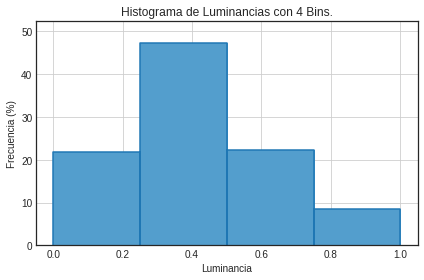

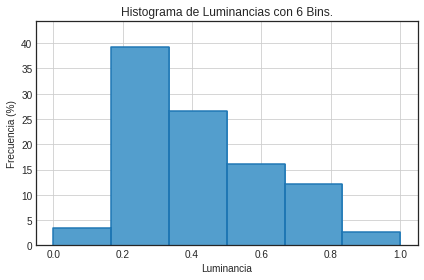

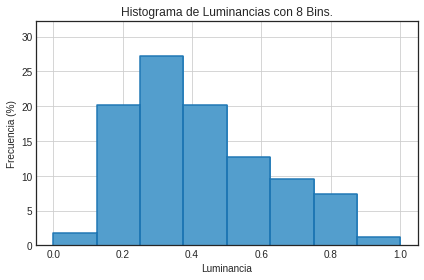

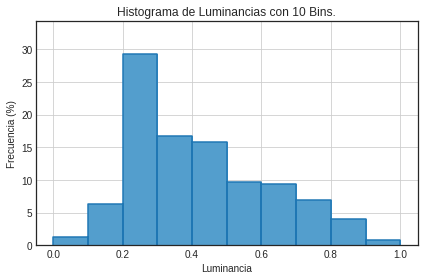

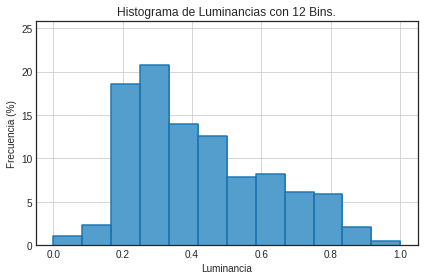

In [134]:
#Abro la img en PNG como un arreglo
im = open_img('/content/histogram-medio.png')  #

print('Grafico los histogramas para ' ,  list(range(4,13,2)), 'bins')

#Gragico  en diferentes plots 
print('Grafico un histograma por gráfico')
for nBins in list(range(4,13,2)):
  HistY(im,nBins)
  plt.show()
  

#Segunda Parte:
## Demuestro que con la variación de una constante, Alfa, por la luminancia Y, no se corrige la imágen.



Tamaño del arreglo (171, 252, 4) donde 171 x 252 es el tamaño de la imágen en píxeles, y  4 es el valor RGB de cada uno de dichos píxeles


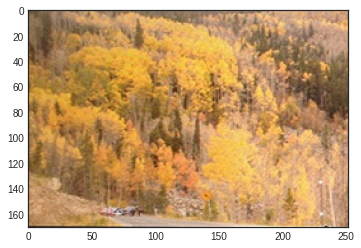

In [ ]:
#@title ## Image Luminance (Y) and Chromatizity (IQ) 
#@markdown You can use your image or use mine: imageio:chelsea.png
#@markdown ---
#@markdown ### Enter an Image path:
file_path ='/content/histogram-medio.png' #@param {type:"string"}
#@markdown ---

#Abro la img en PNG como un arreglo
im =open_img(file_path)
plt.imshow(im)

Luminancia: -0.5 * Y
A continuación se muestra la imágen original (izquierda) y la modificada (derecha)


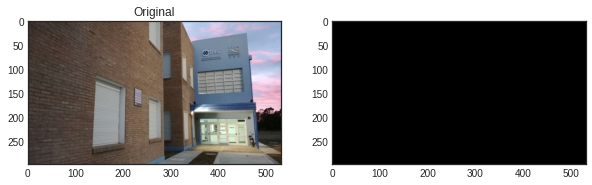

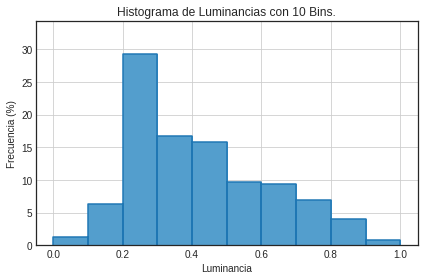

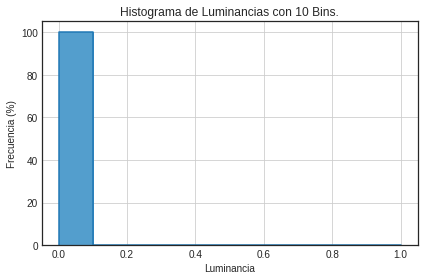

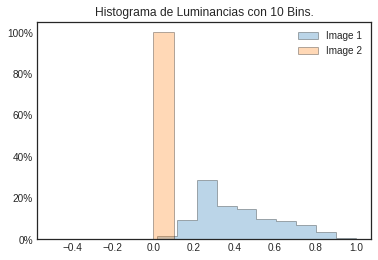

In [126]:
#@title ## Cambio los factores de Luminancia y Crominancia en el espacio YIQ de una imágen
#@markdown  Seleccione los valores a modificar:

Luminancia=0.9 #@param {type:"slider", min:-4, max:4, step:0.1}


print('Luminancia:',Luminancia,'* Y')
print('A continuación se muestra la imágen original (izquierda) y la modificada (derecha)')
ImMod=ModifyYIQ(im,Luminancia,1)


fig = plt.figure(figsize=(10, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(im)
plt.title('Original')
fig.add_subplot(1, 2, 2)
plt.imshow(ImMod)
plt.show()
HistPlotx2(im,ImMod,10)

Implementar las funciones: Lineal a trozos para un valor Y_min y Y_max como parámetros de la función, raíz cuadrada y potencia cuadrática. Para estas usar las imágenes anteriores y mostrar cómo cambio la imagen y el histograma después de aplicar el filtro a la imagen.

#**Tercera Parte**

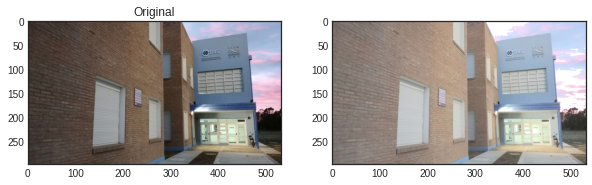

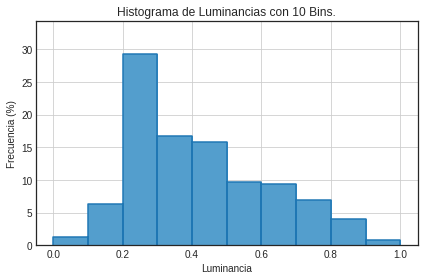

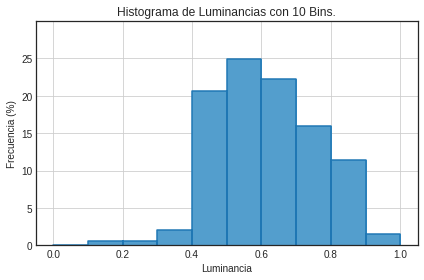

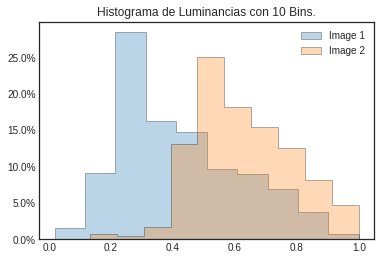

In [127]:
#@title ## Operaciones de Luminancia 
#@markdown  Seleccione los valores a modificar:

Operacion = 'Raíz cuadrada' #@param ["'Raíz cuadrada'", "'Potencia cuadrática'","'Lineal a trozos'"] {type:"raw"}

if (Operacion =='Lineal a trozos'):
  Ymin = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
  Ymax = 0.8 #@param {type:"slider", min:0, max:1, step:0.1}
  ImMod=ModifyYPWLinear(im,Ymin,Ymax)
  
else:
  ImMod=Yoperated(Operacion, im)


fig = plt.figure(figsize=(10, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(im)
plt.title('Original')
fig.add_subplot(1, 2, 2)
plt.imshow(ImMod)
plt.show()
HistPlotx2(im,ImMod,10)
# Save image
imgName='imModified_'+Operacion+'.png'
#imageio.imwrite(imgName, ImMod.astype(np.uint8))

#**Análisis**

A continuación se operan diferentes imágenes con las operaciones vistas anteriormente sobre su histograma de luminancias, para generar un análisis cualitativo.
Se utiliza una imágen con luminancia mayormente en el centro del histograma para analizar el efecto de recortar en Ymin a Ymax el histograma y luego extenderlo a $[0,1]$. Al tomar como extremos $[0.3,0.8]$ se logran ver mejor detalles de las tonalidades del cielo, pero cortando un poco mas ya se van píxeles a blanco. En el presente caso no se cortó de manera simétrica, que sería lo correcto.

Imágen con luminancia mayormente en el centro del histograma
Tamaño del arreglo (475, 709, 3) donde 475 x 709 es el tamaño de la imágen en píxeles, y  3 es el valor RGB de cada uno de dichos píxeles


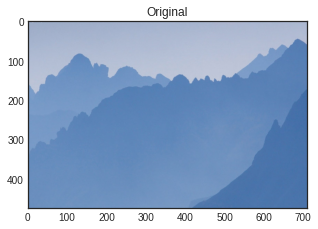

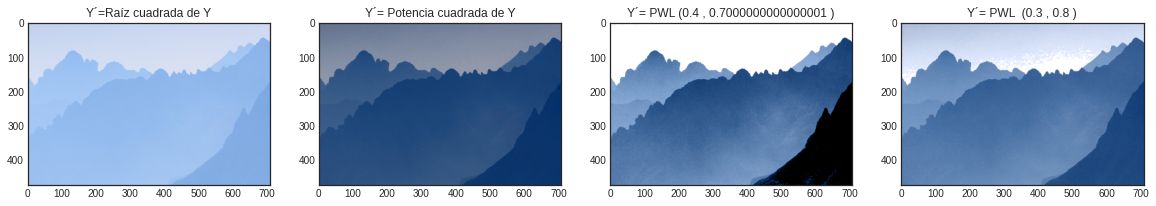

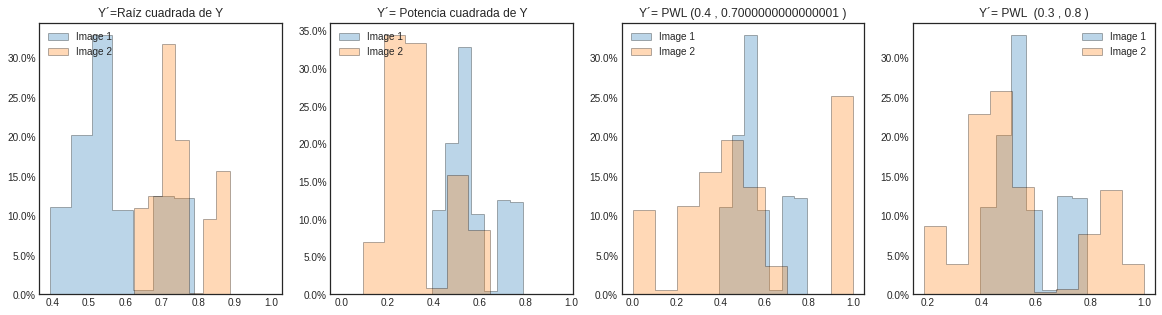

In [ ]:
print('Imágen con luminancia mayormente en el centro del histograma')
imMedio =open_img('/content/003626_1000px.png')
PlotFcns4Analisys(imMedio,0.3,0.8)



Imágen Brillante
Tamaño del arreglo (121, 173, 3) donde 121 x 173 es el tamaño de la imágen en píxeles, y  3 es el valor RGB de cada uno de dichos píxeles


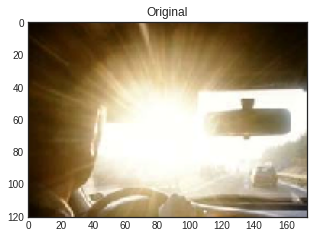

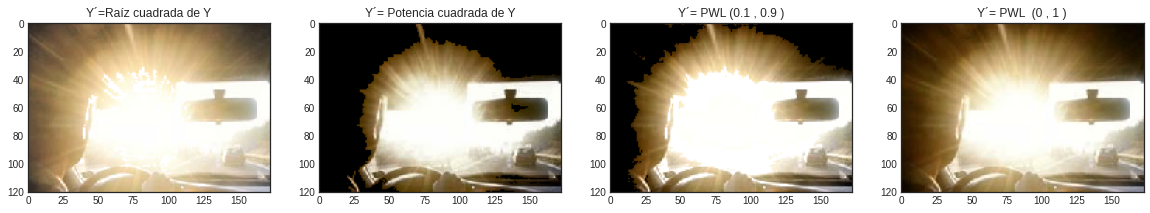

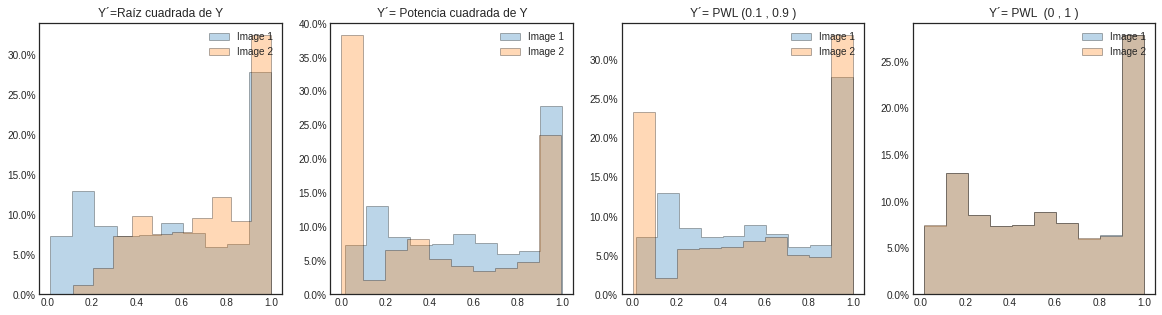

Imágen Oscura
Tamaño del arreglo (300, 532, 3) donde 300 x 532 es el tamaño de la imágen en píxeles, y  3 es el valor RGB de cada uno de dichos píxeles


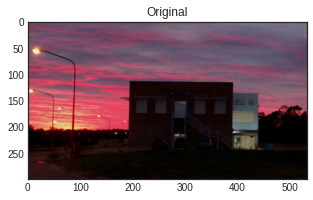

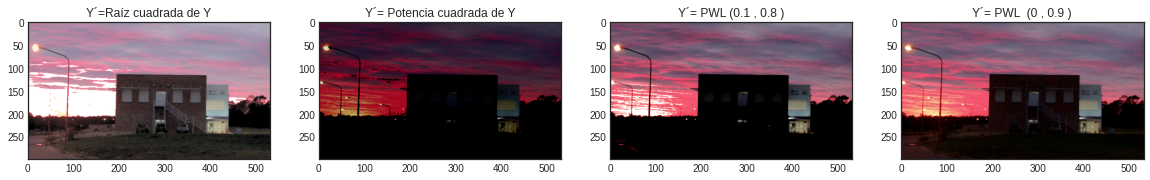

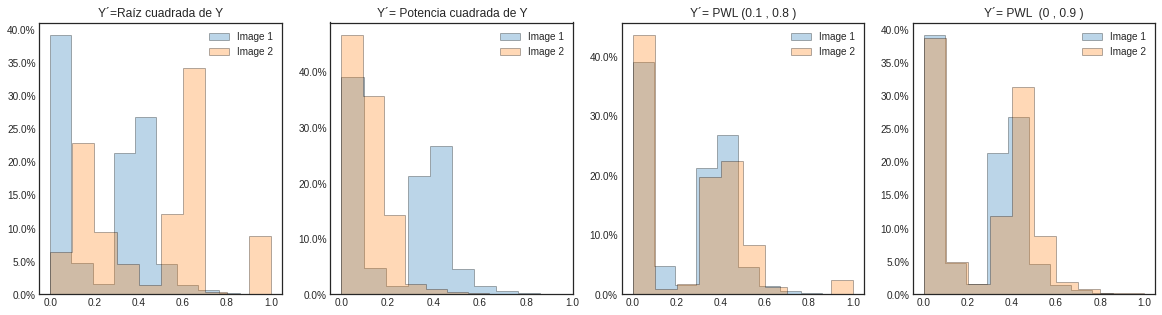

In [ ]:

print('Imágen Brillante')
imBr =open_img('/content/imBrilla.png')
PlotFcns4Analisys(imBr,0,1)
print('Imágen Oscura')
imOsc=open_img('/content/imOsc.png')


PlotFcns4Analisys(imOsc,0,0.9)

La función **raíz cuadrada** de Y, desparrama luminancias bajas y comprime las altas. Las bajas se van a blanco muchas veces. Es aconsejable en imágenes oscuras. En la **imágen oscura** mostrada, se puede observar que con la raíz cuadrada se ven detalles que antes no, en las zonas del edificio y alrededores, mientras que con la **potencia cuadrada** se va a negro o muy oscuro la mayor parte de la imágen.

La función **potencia cuadrada** de Y, desparrama luminancias altas y comprime las bajas. Las altas se van a negro muchas veces. Es aconsejable en imágenes claras. En el caso de la **imágen brillante** mostrada, al generar la potencia cuadrada permite ver algunos detalles en las zonas donde reduce la luminancia, como el auto que va adelante y la zona del tablero. En el caso en que se aplica la **raíz cuadrada**, se puede ver que el brillo hace que se pierdan detalles y lleva a blanco varios píxeles, siendo notorio esto en la parte superior del parabrisas.

En el caso de las funciones lineales a tramos en cada caso, en el caso de la imágen brillante no es aconsejable ya que el histograma ocupa todo el eje, y perdería información. Con la imágen oscura se fijaron umbrales desvalanceados, pero aún así se logra ver mejor la zona de ingreso lateral al edificio.


A continuación se operan las **imágenes brillante y oscura** con la **multiplicación por diferentes factores**, de la luminancia Y. En el caso de la imágen brillante, los factores son menores a uno, y con la oscura, mayores a la unidad. De esta frma se atenúa el efecto dominante, pero no ayuda demasiado en la visualización, ya que el histograma se corre por completo hacia uno u otro lado, haciendo que se pierda información del lado comprimido; y mejorando levemente el lado expandido. 

Tamaño del arreglo (121, 173, 3) donde 121 x 173 es el tamaño de la imágen en píxeles, y  3 es el valor RGB de cada uno de dichos píxeles
Tamaño del arreglo (300, 532, 3) donde 300 x 532 es el tamaño de la imágen en píxeles, y  3 es el valor RGB de cada uno de dichos píxeles


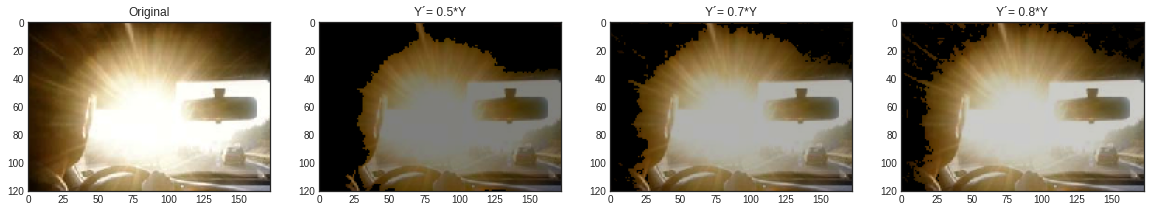

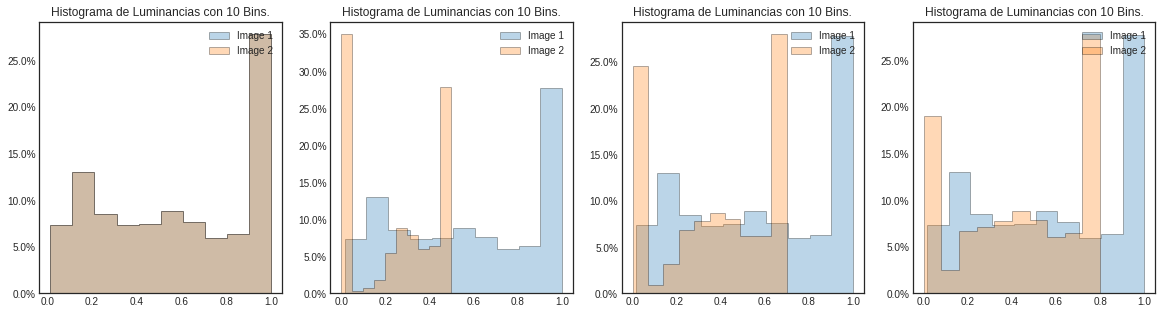

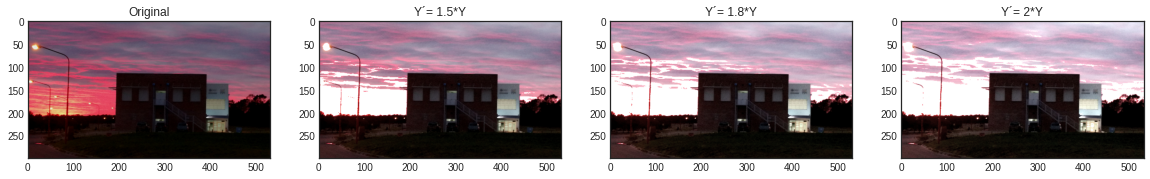

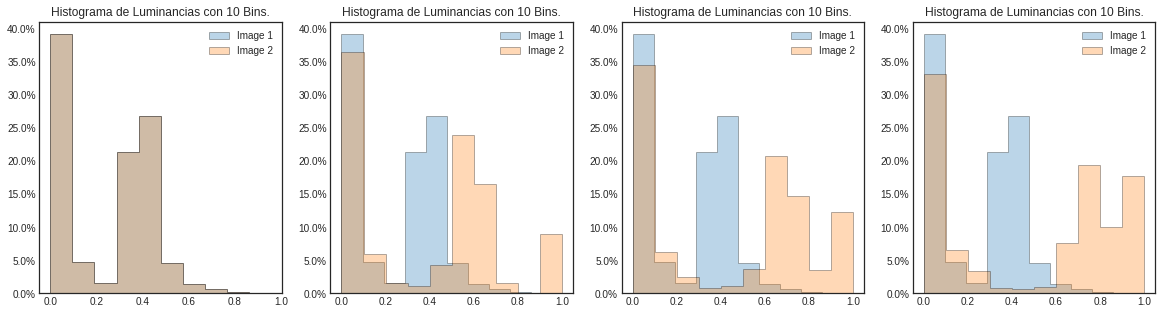

In [ ]:
imBr =open_img('/content/imBrilla.png')
imOsc=open_img('/content/imOsc.png')

ImBr05=ModifyYIQ(imBr,0.5,1)
ImBr07=ModifyYIQ(imBr,0.7,1)
ImBr08=ModifyYIQ(imBr,0.8,1)
ImOsc15=ModifyYIQ(imOsc,1.5,1)
ImOsc2=ModifyYIQ(imOsc,2,1)
ImOsc18=ModifyYIQ(imOsc,1.8,1)


fig = plt.figure(figsize=(20, 40))
fig.add_subplot(1,4, 1)
plt.imshow(imBr)
plt.title('Original')
fig.add_subplot(1,4, 2)
plt.imshow(ImBr05)
plt.title('Y´= 0.5*Y')
fig.add_subplot(1,4, 3)
plt.imshow(ImBr07)
plt.title('Y´= 0.7*Y')
fig.add_subplot(1,4, 4)
plt.imshow(ImBr08)
plt.title('Y´= 0.8*Y')
plt.show()
fig = plt.figure(figsize=(20, 5))
fig.add_subplot(1,4, 1)
Histx2Only(imBr,imBr,10)
fig.add_subplot(1,4, 2)
Histx2Only(imBr,ImBr05,10)
fig.add_subplot(1,4, 3)
Histx2Only(imBr,ImBr07,10)
fig.add_subplot(1,4, 4)
Histx2Only(imBr,ImBr08,10)
plt.show()

fig = plt.figure(figsize=(20, 40))
fig.add_subplot(1,4, 1)
plt.imshow(imOsc)
plt.title('Original')
fig.add_subplot(1,4, 2)
plt.imshow(ImOsc15)
plt.title('Y´= 1.5*Y')
fig.add_subplot(1,4, 3)
plt.imshow(ImOsc18)
plt.title('Y´= 1.8*Y')
fig.add_subplot(1,4, 4)
plt.imshow(ImOsc2)
plt.title('Y´= 2*Y')
plt.show()
fig = plt.figure(figsize=(20, 5))
fig.add_subplot(1,4, 1)
Histx2Only(imOsc,imOsc,10)
fig.add_subplot(1,4, 2)
Histx2Only(imOsc,ImOsc15,10)
fig.add_subplot(1,4, 3)
Histx2Only(imOsc,ImOsc18,10)
fig.add_subplot(1,4, 4)
Histx2Only(imOsc,ImOsc2,10)
plt.show()